In [15]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.initializers import GlorotUniform
from tqdm import tqdm  # Import tqdm for the progress bar

Hop size - 160 
Window Size - 512 
fft_size = 512

Use weight initialization 

In [16]:
def preprocess_data(file_path, max_time_steps=300, sample_rate=16000, duration=3, n_mels=128,hop_length=160,win_length=512,n_fft=512):
    audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels,hop_length=hop_length, win_length=win_length,n_fft=n_fft)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    return mel_spectrogram

In [17]:
def load_and_preprocess_audio(file_path,n_fft=512, hop_length=160, win_length=512,max_length=300):
    ''' Given an audio signal, computes power (or log power) spectrogram '''
    # Load the audio signal
    y, _ = librosa.load(file_path,sr=16000)

    # Compute the short-time Fourier transform (STFT)
    D = np.abs(librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2

    # Ensure the spectrogram is not all zeros
    D = np.maximum(D, 1e-5)

    # Take the logarithm
    D = np.log(D)

    # Ensure that the LFCC arrays have the same shape
    if D.shape[1] < max_length:
        # If shorter, pad with zeros
        pad_width = ((0, 0), (0, max_length - D.shape[1]))
        D = np.pad(D, pad_width, mode='constant', constant_values=0)
    elif D.shape[1] > max_length:
        # If longer, truncate
        D = D[:, :max_length]

    return D.T

In [18]:
# Set your file paths and constants
TRAINING_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.train.trn.txt'
TRAINING_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_train/flac'
VALIDATION_DATA = '/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_dev/flac'
VALIDATION_LABEL = '/data/common_source/datasets/asvpoof-2019-dataset/PA/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.dev.trl.txt'
SAMPLE_RATE = 16000  # Adjust if your sample rate is different
DURATION = 3  # Adjust the duration of your audio samples
N_MELS = 128  # Adjust the number of mel filters

In [20]:
# Load labels for training Data
train_labels = {}

with open(TRAINING_LABEL, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    train_labels[file_name] = label

X = []
y = []

max_length = 300  # Define the maximum time steps for your model


for file_name, label in train_labels.items():
    file_path = os.path.join(TRAINING_DATA, file_name + ".flac")

    # Use the preprocess_data function
    mel_spectrogram = load_and_preprocess_audio(file_path,max_length=max_length)

    X.append(mel_spectrogram)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Reshape input data to match the required input shape for ResNet
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))

In [21]:
# Define input shape and number of classes
input_shape = (X.shape[1], X.shape[2], 1)
num_classes = 2  # Assuming you have two classes (0 and 1)

print(input_shape)

(300, 257, 1)


In [23]:
# Load and preprocess evaluation data
eval_X = []
eval_y = []

with open(VALIDATION_LABEL, 'r') as eval_label_file:
    eval_lines = eval_label_file.readlines()

eval_labels = {}

for line in eval_lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    eval_labels[file_name] = label

max_time_steps = 300  # Define the maximum time steps for your model

# Use tqdm to add a progress bar
for file_name, label in tqdm(eval_labels.items(), desc='Loading and preprocessing evaluation data', unit='file'):
    file_path = os.path.join(VALIDATION_DATA, file_name + ".flac")

    # Use the preprocess_data function
    mel_spectrogram = load_and_preprocess_audio(file_path, max_length=max_time_steps)

    eval_X.append(mel_spectrogram)
    eval_y.append(label)

eval_X = np.array(eval_X)
eval_y = np.array(eval_y)

# Reshape input data to match the required input shape for ResNet
eval_X = eval_X.reshape((eval_X.shape[0], eval_X.shape[1], eval_X.shape[2], 1))

Loading and preprocessing evaluation data:   1%|          | 198/29700 [00:00<01:15, 389.38file/s]

Loading and preprocessing evaluation data: 100%|██████████| 29700/29700 [01:21<00:00, 363.15file/s]


In [24]:
def init_weights():
    initializer = GlorotUniform()
    return initializer

In [25]:
# Define the ResNet block
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, kernel_initializer=init_weights())(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer=init_weights())(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer=init_weights())(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the ResNet model
def build_resnet(input_shape):
    input_tensor = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_initializer=init_weights())(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet blocks
    for size in [64, 128, 256, 512]:
        x = resnet_block(x, size, conv_shortcut=True)
        x = resnet_block(x, size)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=2, activation='softmax', kernel_initializer=init_weights())(x)

    model = models.Model(inputs=input_tensor, outputs=x, name='resnet_model')
    return model

In [26]:
# Build ResNet model
resnet_model = build_resnet(input_shape)

In [27]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Display the model summary
resnet_model.summary()

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 150, 129, 64  3200        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_21 (BatchN  (None, 150, 129, 64  256        ['conv2d_21[0][0]']              
 ormalization)                  )                                                      

In [29]:
# Train the model
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

NUM_EPOCHS = 100
history = resnet_model.fit(X_train, y_train, epochs=NUM_EPOCHS,
                            validation_data=(eval_X, eval_y), callbacks=[early_stopping])

2023-11-29 04:51:31.932943: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13322880000 exceeds 10% of free system memory.
2023-11-29 04:51:41.004630: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13322880000 exceeds 10% of free system memory.


Epoch 1/100
1349/1350 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9025

In [30]:
# Evaluate the model on the test set
loss, accuracy = resnet_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')

# Evaluate the model on the separate evaluation dataset
eval_loss, eval_accuracy = resnet_model.evaluate(eval_X, eval_y)
print(f'Evaluation Loss: {eval_loss:.4f}, Evaluation Accuracy: {eval_accuracy * 100:.2f}%')

  2/338 [..............................] - ETA: 24s - loss: 0.1648 - accuracy: 0.9219

338/338 [==============================] - 25s 74ms/step - loss: 0.1898 - accuracy: 0.9045
Test Loss: 0.1898, Test Accuracy: 90.45%


2023-11-28 11:51:57.046299: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB (rounded to 4561920000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-28 11:51:57.046393: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2023-11-28 11:51:57.046425: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 128, Chunks in use: 125. 32.0KiB allocated for chunks. 31.2KiB in use in bin. 16.9KiB client-requested in use in bin.
2023-11-28 11:51:57.046445: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 56, Chunks in use: 55. 28.0KiB allocated for chunks. 27.5KiB in use in bin. 27.5KiB client-requested in use in bin.
2023-11-28 11:51:57.046

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

of size 1024 next 484
2023-11-28 11:51:57.050065: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e6400 of size 1024 next 485
2023-11-28 11:51:57.050076: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e6800 of size 1024 next 487
2023-11-28 11:51:57.050087: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e6c00 of size 1024 next 488
2023-11-28 11:51:57.050098: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e7000 of size 1024 next 489
2023-11-28 11:51:57.050109: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e7400 of size 1024 next 490
2023-11-28 11:51:57.050120: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e7800 of size 1536 next 246
2023-11-28 11:51:57.050132: I tensorflow/core/common_runtime/bfc_allocator.cc:1083] InUse at 7f126c1e7e00 of size 278528 next 325
2023-11-28 11:51:57.050143: I tensorflow/core/common_runtime/bfc_allocator.cc:10

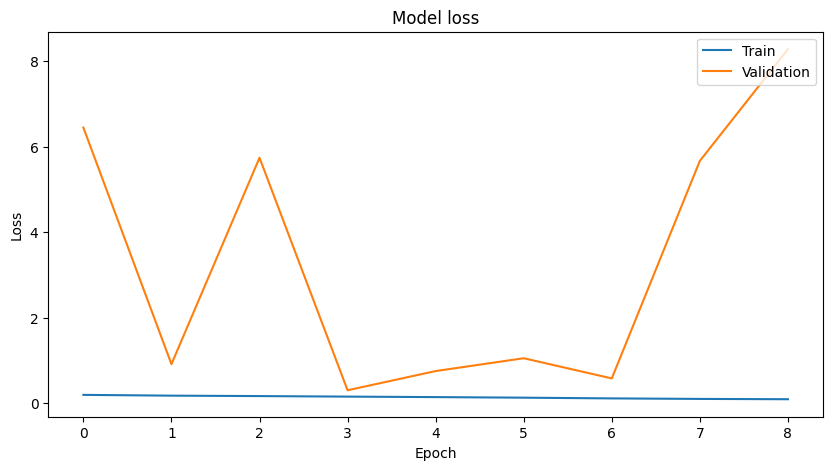

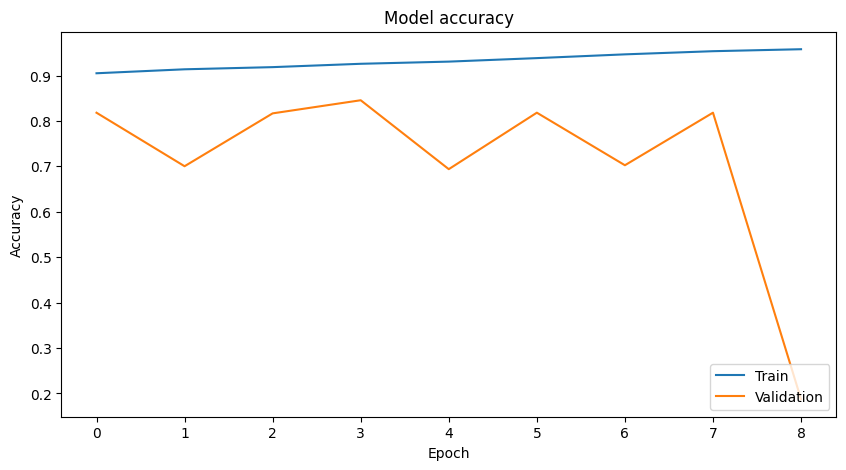

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [32]:
# Save the trained model
resnet_model.save("models/basic_resnet_PA_with_weights.h5")

: 